In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as pyplot
import random 
from pprint import pprint
import pydotplus
import graphviz

# Interchange last column with label column

In [3]:
df = pd.read_csv("1.csv")
# Adding Noise
# for i in np.random.randint(0, df.shape[0], 1000):
#     df['class'][i] = np.random.choice(list(set(df['class'])))
df = df.rename(columns={"class": "label"})
first_column = df.pop("label")
df.insert(len(df.columns),'label',first_column)



# Removed '?' by mode value

In [4]:
mean_of_stalkroot = df["stalk-root"].mode()[0]
df["stalk-root"] = df["stalk-root"].replace("?",mean_of_stalkroot)

In [5]:
def train_test_split(df, test_size):

    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)

    return train_df, test_df


In [6]:

train_df, test_df = train_test_split(df=df,test_size=0.2)


In [7]:
train_df.info()




<class 'pandas.core.frame.DataFrame'>
Int64Index: 6499 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 6499 non-null   object
 1   cap-surface               6499 non-null   object
 2   cap-color                 6499 non-null   object
 3   bruises                   6499 non-null   object
 4   odor                      6499 non-null   object
 5   gill-attachment           6499 non-null   object
 6   gill-spacing              6499 non-null   object
 7   gill-size                 6499 non-null   object
 8   gill-color                6499 non-null   object
 9   stalk-shape               6499 non-null   object
 10  stalk-root                6499 non-null   object
 11  stalk-surface-above-ring  6499 non-null   object
 12  stalk-surface-below-ring  6499 non-null   object
 13  stalk-color-above-ring    6499 non-null   object
 14  stalk-color-below-ring  

# Check purity of our class

The first column is our "class" column or dependent variable and the rest are label's or independent variables.

In [8]:
def check_purity(data):
    label_columns = data[:,-1]
    unique_classes = np.unique(label_columns)
    if len(unique_classes) == 1:
        return True
    else:
        return False

In [9]:
def classify_data(data):
    label_columns = data[:,-1]
    unique_classes, count_unique_classes = np.unique(label_columns,return_counts=True)
    index = count_unique_classes.argmax()
    return unique_classes[index]


# Potential splits 

In [10]:
def get_potential_splits(data):
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns-1):
        values = data[:, column_index]
        unique_values = np.unique(values)
        if len(unique_values) > 1:
            potential_splits[column_index] = unique_values
    return potential_splits


In [11]:
def split_data(data, split_column, split_value):
    split_column_values = data[:, split_column]
    data_below = data[split_column_values == split_value]
    data_above = data[split_column_values != split_value]
    return data_below, data_above


In [12]:
split_data(train_df.values,1,0.6)

(array([], shape=(0, 23), dtype=object),
 array([['x', 's', 'n', ..., 's', 'u', 'p'],
        ['x', 's', 'y', ..., 'n', 'g', 'e'],
        ['b', 's', 'w', ..., 'n', 'm', 'e'],
        ...,
        ['f', 's', 'n', ..., 'c', 'l', 'e'],
        ['k', 'y', 'n', ..., 'v', 'l', 'p'],
        ['x', 's', 'n', ..., 'c', 'l', 'e']], dtype=object))

# Calculating Entropy 

In [13]:
def calculate_entropy(data):
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy


In [14]:
def calculate_overall_entropy(data_below, data_above):
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy = (p_data_below * calculate_entropy(data_below)
                       + p_data_above * calculate_entropy(data_above))

    return overall_entropy


In [15]:
def determine_best_split(data, potential_splits):
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(
                data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(
                data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    return best_split_column, best_split_value


# Decision Tree Algorithm

In [16]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    if counter == 0:
        global COLUMN_HEADERS
        COLUMN_HEADERS = df.columns
        data = df.values
    else:
        data = df
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        return classification
    else:
        counter += 1
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(
            data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        feature_name = COLUMN_HEADERS[split_column]
        question = "{} = {}".format(feature_name, split_value)        
        sub_tree = {question: []}
        yes_answer = decision_tree_algorithm(
            data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(
            data_above, counter, min_samples, max_depth)
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        return sub_tree


In [47]:
tree = decision_tree_algorithm(train_df)
pprint(tree)


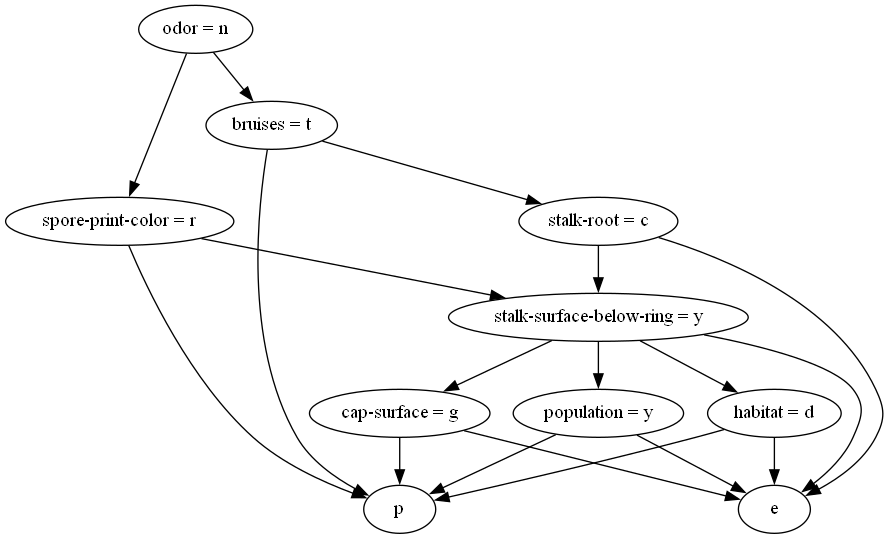

In [18]:
import pydot
from IPython.display import Image


def draw(parent_name, child_name):
    if not isinstance(child_name,dict):
        edge = pydot.Edge(parent_name, child_name)
        graph.add_edge(edge)
        
def visit(node, parent=None):
    if isinstance(node,list):
        for item in node:
            if parent:
                draw(parent,item)
            if isinstance(item,list) or isinstance(item,dict):
                visit(item,parent)
    else: 
        for k, v in node.items():  
            if isinstance(v, list):
                if parent:
                    draw(parent, k)
                visit(v, k)
            else:
                draw(parent, k)
                draw(k, (k)+'_'+(v))


graph = pydot.Dot(graph_type='digraph')
visit(tree)
graph.write_png('tree.png')
Image(filename='tree.png')



In [19]:
example = test_df.iloc[5]
example


cap-shape                   f
cap-surface                 f
cap-color                   g
bruises                     t
odor                        n
gill-attachment             f
gill-spacing                c
gill-size                   b
gill-color                  n
stalk-shape                 t
stalk-root                  b
stalk-surface-above-ring    s
stalk-surface-below-ring    s
stalk-color-above-ring      w
stalk-color-below-ring      w
veil-type                   p
veil-color                  w
ring-number                 o
ring-type                   p
spore-print-color           k
population                  y
habitat                     d
label                       e
Name: 2449, dtype: object

In [20]:
def classify_example(example, tree):
    if not isinstance(tree, dict):
        return tree
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")
    # ask question
    
    if str(example[feature_name]) == value:
        answer = tree[question][0]
    else:
        answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer

    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)


In [21]:
classify_example(example=example,tree=tree)


'e'

In [22]:
def make_predictions(df, tree):

    if len(df) != 0:
        predictions = df.apply(classify_example, args=(tree,), axis=1)
    else:
        predictions = pd.Series()

    return predictions


In [23]:
def calculate_accuracy(df, tree):
    predictions = make_predictions(df, tree)
    predictions_correct = predictions == df.label
    accuracy = predictions_correct.mean()

    return accuracy


In [24]:
calculate_accuracy(test_df, tree)*100


100.0

# Pruning of Decision Tree

## 1. Pre Pruning

In [25]:
df_train_train, df_train_val = train_test_split(df=train_df, test_size=0.2)
train_tree = decision_tree_algorithm(df_train_train)


In [26]:
def generate_best_accuracy():
    x = []
    for i in range(1,6):
        test_tree = decision_tree_algorithm(df_train_train,max_depth=i)
        print(i)
        pprint(test_tree)
        y = calculate_accuracy(df_train_val,test_tree)
        x.append(y)
    return x

def get_optimimum_depth():
    opt_acc = 0.0
    depth = 1
    while opt_acc != 1.0:
        opt_tree = decision_tree_algorithm(df_train_train, max_depth=depth)
        opt_acc = calculate_accuracy(df_train_val,opt_tree)
        pprint(opt_tree)
        depth += 1
    return depth



In [27]:
generate_best_accuracy()
print("The optimimum depth is : " + str(get_optimimum_depth())) 

1
{'odor = n': ['e', 'p']}
2
{'odor = n': [{'spore-print-color = r': ['p', 'e']},
              {'bruises = t': ['e', 'p']}]}
3
{'odor = n': [{'spore-print-color = r': ['p',
                                         {'stalk-surface-below-ring = y': ['p',
                                                                           'e']}]},
              {'bruises = t': [{'stalk-root = c': ['e', 'p']}, 'p']}]}
4
{'odor = n': [{'spore-print-color = r': ['p',
                                         {'stalk-surface-below-ring = y': [{'population = y': ['e',
                                                                                               'p']},
                                                                           {'cap-surface = g': ['p',
                                                                                                'e']}]}]},
              {'bruises = t': [{'stalk-root = c': ['e',
                                                   {'stalk-surface-below-ring

## 2. Post Pruning

In [28]:
def filter_df(df, question):
    feature, comparison_operator, value = question.split()
    df_yes = df[df[feature].astype(str) == value]
    df_no = df[df[feature].astype(str) != value]
    return df_yes, df_no

In [29]:
def determine_leaf(df_train):
    return df_train.label.value_counts().index[0]


In [30]:
def determine_errors(df_val, tree):
    predictions = make_predictions(df_val, tree)
    actual_values = df_val.label
    return sum(predictions != actual_values)


In [31]:
def pruning_result(tree, df_train, df_val):

    leaf = determine_leaf(df_train)
    errors_leaf = determine_errors(df_val, leaf)
    errors_decision_node = determine_errors(df_val, tree)

    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree

In [32]:
def post_pruning(tree, df_train, df_val):
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree, df_train, df_val)
    else:
        df_train_yes, df_train_no = filter_df(df_train, question)
        df_val_yes, df_val_no = filter_df(df_val, question)

        if isinstance(yes_answer, dict): 
            yes_answer = post_pruning(yes_answer, df_train_yes, df_val_yes)

        if isinstance(no_answer, dict): 
            no_answer = post_pruning( no_answer, df_train_no, df_val_no)

        tree = {question: [yes_answer, no_answer]}

        return pruning_result(tree, df_train, df_val)


In [33]:
def pruning_result(tree, df_train, df_val):

    leaf = determine_leaf(df_train)
    errors_leaf = determine_errors(df_val, leaf)
    errors_decision_node = determine_errors(df_val, tree)
    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree


In [34]:
pruned_tree = post_pruning(train_tree,df_train=df_train_train,df_val=df_train_val)
pprint(pruned_tree)

{'odor = n': [{'spore-print-color = r': ['p',
                                         {'stalk-surface-below-ring = y': [{'population = y': ['e',
                                                                                               'p']},
                                                                           {'cap-surface = g': ['p',
                                                                                                'e']}]}]},
              {'bruises = t': [{'stalk-root = c': ['e',
                                                   {'stalk-surface-below-ring = y': ['e',
                                                                                     {'habitat = d': ['e',
                                                                                                      'p']}]}]},
                               'p']}]}


In [35]:
metrics = {"max_depth": [], "acc_tree": [], "acc_tree_pruned": []}
for n in range(5,10):

    df_train, df_test = train_test_split(df, test_size=0.15)
    df_train, df_val = train_test_split(df_train, test_size=0.15)
    tree = decision_tree_algorithm(
        df_train, max_depth=n)
    tree_pruned = post_pruning(
        tree, df_train, df_val)
    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(df_test, tree))
    print(n,calculate_accuracy(df_test,tree))
    metrics["acc_tree_pruned"].append(calculate_accuracy(df_test, tree_pruned))
    print(n, calculate_accuracy(df_test, tree_pruned))

df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index("max_depth")


5 0.9991796554552912
5 0.9983593109105825
6 1.0
6 0.9983593109105825
7 1.0
7 1.0
8 1.0
8 0.9975389663658737
9 1.0
9 1.0


<AxesSubplot:xlabel='max_depth'>

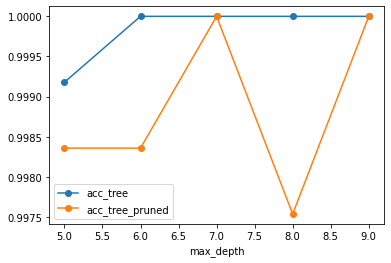

In [36]:
df_metrics.plot(marker="o")

In [37]:
def display_CNF(dt, s=[], d=1):
       if dt == str(dt):
            ss = ""
            for i in s:
                ss = ss+i
            print(ss.strip(" "), "\b\b->",dt)
            return
       for k in dt.keys():
            for i in range(len(dt[k])):
               s.append( (" ~" if i == 0 else "" ) + "("+k.strip()+") ^ ")
               display_CNF(dt[k][i], s,d+1)
               del s[len(s)-1]


In [38]:
display_CNF(tree_pruned)
# pprint(tree_pruned)


~(odor = n) ^  ~(spore-print-color = r) -> p
~(odor = n) ^ (spore-print-color = r) ^  ~(stalk-surface-below-ring = y) ^  ~(population = y) -> e
~(odor = n) ^ (spore-print-color = r) ^  ~(stalk-surface-below-ring = y) ^ (population = y) -> p
~(odor = n) ^ (spore-print-color = r) ^ (stalk-surface-below-ring = y) ^  ~(gill-size = n) ^  ~(population = c) -> p
~(odor = n) ^ (spore-print-color = r) ^ (stalk-surface-below-ring = y) ^  ~(gill-size = n) ^ (population = c) -> e
~(odor = n) ^ (spore-print-color = r) ^ (stalk-surface-below-ring = y) ^ (gill-size = n) -> e
(odor = n) ^  ~(bruises = t) ^  ~(stalk-root = c) -> e
(odor = n) ^  ~(bruises = t) ^ (stalk-root = c) ^  ~(stalk-surface-below-ring = y) -> e
(odor = n) ^  ~(bruises = t) ^ (stalk-root = c) ^ (stalk-surface-below-ring = y) ^  ~(habitat = d) -> e
(odor = n) ^  ~(bruises = t) ^ (stalk-root = c) ^ (stalk-surface-below-ring = y) ^ (habitat = d) -> p
(odor = n) ^ (bruises = t) -> p


# Comparison with SkLearn Decision Tree

In [39]:
from sklearn import tree 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [40]:
df2 = pd.read_csv("1.csv")
X = df2.drop(columns=['class'])
Y = (df2['class'] == 'p').astype(np.int32)
X_new = pd.get_dummies(X, drop_first=True) 


## Train Test Split

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.2)
dt = tree.DecisionTreeClassifier()
dt.fit(X_train, Y_train)


DecisionTreeClassifier()

In [42]:
dt.predict(X_test)

array([0, 1, 1, ..., 0, 0, 1])

## Accuracy

In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(dt.predict(X_test), Y_test)


1.0